## Инициализация

### Импорты

In [94]:
from typing import Annotated
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Константы

In [95]:
U: Annotated[np.longdouble, 'Скорость вращения Земли'] = np.longdouble(np.deg2rad(15)/3_600)
R: Annotated[np.longdouble, 'Радиус Земли'] = np.longdouble(6_371_000)
g: Annotated[np.longdouble, 'Ускорение свободного падения на Земле'] = np.longdouble(9.8067)
v: Annotated[np.longdouble, 'Частота Шулера'] = np.longdouble(np.sqrt(g / R))
T: Annotated[np.longdouble, 'Период частоты Шулера'] = np.longdouble(np.sqrt(np.divide(R*4*np.pi*np.pi, g*3600)))

### Начальные условия

In [96]:
# Временной интервал анализа
start_time: Annotated[int, 'Вермя начала измерения'] = 0
end_time: Annotated[int, 'Вермя окончания измерения'] = 1.5*60*60   # 1.5 часа
n: Annotated[int, 'Количество измерений в секунду'] = 4

In [97]:
# Начальная широта и долгота
base_latitude: Annotated[np.longdouble, 'Начальная широта'] = np.longdouble(np.deg2rad(56)) # Москва
base_longitude: Annotated[np.longdouble, 'Начальная долгота'] = np.longdouble(0.0) # Гринвичевский мередиан

In [98]:
# Начальные углы ориентации
heading: Annotated[np.longdouble, 'Курс'] = np.longdouble(np.deg2rad(45))
pitch: Annotated[np.longdouble, 'Тангаж'] = np.longdouble(np.deg2rad(0))
roll: Annotated[np.longdouble, 'Крен'] = np.longdouble(np.deg2rad(5))

In [99]:
# Дрейф гироскопов (ДУС)
dw_bx: Annotated[np.longdouble, 'Дрейф ДУС по ox'] = np.longdouble(np.deg2rad(-0.4)/3600)
dw_by: Annotated[np.longdouble, 'Дрейф ДУС по oy'] = np.longdouble(np.deg2rad(-0.4)/3600)
dw_bz: Annotated[np.longdouble, 'Дрейф ДУС по oz'] = np.longdouble(np.deg2rad( 0.1)/3600)
dw_b = [dw_bx, dw_by, dw_bz]

In [100]:
# Дрейф акселерометров
da_bx: Annotated[np.longdouble, 'Дрейф акселерометра по ox'] = np.longdouble(( 0.2*g)/1_000)
da_by: Annotated[np.longdouble, 'Дрейф акселерометра по oy'] = np.longdouble((-0.1*g)/1_000)
da_bz: Annotated[np.longdouble, 'Дрейф акселерометра по oz'] = np.longdouble(( 0.2*g)/1_000)
da_b = [da_bx, da_by, da_bz]

In [101]:
# Ошибка выставки по заданному курсу (ЗК)
dazimuth_zk: Annotated[np.longdouble, 'Ошибка выставки в азимуте по заданному курсу'] = np.longdouble(np.deg2rad(1))

### Расчёт матрицы направляющих косинусов (МНК) для начального положения БИНС

In [102]:
# np.longdouble(np.deg2rad(45))
# np.longdouble(np.deg2rad(0))
# np.longdouble(np.deg2rad(5))
def calc_body_to_ref(heading: Annotated[np.longdouble, 'Курс'], pitch: Annotated[np.longdouble, 'Тангаж'], roll: Annotated[np.longdouble, 'Крен']) -> np.ndarray[np.longdouble]:
    return np.array([
        [
            np.cos(heading) * np.cos(roll) + np.sin(heading) * np.sin(pitch) * np.sin(roll),
            np.sin(heading) * np.cos(pitch),
            np.cos(heading) * np.sin(roll) - np.sin(heading) * np.sin(pitch) * np.cos(roll)
        ],
        [
            -np.sin(heading) * np.cos(roll) + np.cos(heading) * np.sin(pitch) * np.sin(roll),
            np.cos(heading) * np.cos(pitch),
            -np.sin(heading) * np.sin(roll) - np.cos(heading) * np.sin(pitch) * np.cos(roll)
        ],
        [
            -np.cos(pitch) * np.sin(roll),
            np.sin(pitch),
            np.cos(pitch) * np.cos(roll)
        ]
    ], dtype=np.longdouble)

body_to_ref: Annotated[np.array, 'Матрица перехода от связанной в опорную СК'] = calc_body_to_ref(heading, pitch, roll)
print(f'МНК из связанной в опорную\n{body_to_ref}\n')

ref_to_body: Annotated[np.array, 'Матрица перехода от опорной в связанную СК'] = body_to_ref.T
print(f'МНК из опорной в связанную\n{ref_to_body}')

МНК из связанной в опорную
[[ 0.70441603  0.70710678  0.06162842]
 [-0.70441603  0.70710678 -0.06162842]
 [-0.08715574  0.          0.9961947 ]]

МНК из опорной в связанную
[[ 0.70441603 -0.70441603 -0.08715574]
 [ 0.70710678  0.70710678  0.        ]
 [ 0.06162842 -0.06162842  0.9961947 ]]


# Для неподвижной БИНС

### Проекции дрейфов ДУС и акселерометров на оси опорной СК

In [103]:
# Проекции дрейфов ДУС и акселерометров на оси опорной СК
dw_ox, dw_oy, dw_oz = dw = body_to_ref @ (dw_bx, dw_by, dw_bz)
da_ox, da_oy, da_oz = da = body_to_ref @ (da_bx, da_by, da_bz)

### Проекции скорости вращения Земли и ускорения сил тяжести на оси опорной СК

In [104]:
# Проекции скорости вращения Земли на оси опорной СК
w_ox: Annotated[np.longdouble, 'Проекция угловой скорости вращения в опорной СК по ох'] = np.longdouble(0)
w_oy: Annotated[np.longdouble, 'Проекция угловой скорости вращения в опорной СК по оy'] = np.longdouble(U*np.cos(base_latitude))
w_oz: Annotated[np.longdouble, 'Проекция угловой скорости вращения в опорной СК по оz'] = np.longdouble(U*np.sin(base_latitude))
w_o = [w_ox, w_oy, w_oz]
print(f'Проекции угловой скорости вращения Земли в опорной СК: {w_o} рад/c = {np.rad2deg(w_o)} град/c = {np.rad2deg(w_o)*3_600} град/ч')

Проекции угловой скорости вращения Земли в опорной СК: [0.0, 4.066565549729732e-05, 6.028931359927857e-05] рад/c = [0.         0.00232997 0.00345432] град/c = [ 0.          8.38789355 12.43556359] град/ч


In [105]:
# Проекции ускорения сил тяжести на оси опорной СК
a_ox: Annotated[np.longdouble, 'Проекция ускорения в опорной СК ох'] = np.longdouble(0)
a_oy: Annotated[np.longdouble, 'Проекция ускорения в опорной СК по оy'] = np.longdouble(0)
a_oz: Annotated[np.longdouble, 'Проекция ускорения в опорной СК по оz'] = np.longdouble(g)
a_o = [a_ox, a_oy, a_oz]
print(a_o)

[0.0, 0.0, 9.8067]


### Проекции ускорений и угловых скоростей на оси связанной СК (сигналы акселерометров и ДУС для неподвижной БИНС)

In [106]:
# Проекции скорости вращения Земли на оси связанной СК
w_bx: Annotated[np.longdouble, 'Проекция угловой скорости вращения в связанной СК по ох']
w_by: Annotated[np.longdouble, 'Проекция угловой скорости вращения в связанной СК по оy']
w_bz: Annotated[np.longdouble, 'Проекция угловой скорости вращения в связанной СК по оz']

w_bx, w_by, w_bz = w_b = (ref_to_body @ (w_ox, w_oy, w_oz)) + dw_b
print(f'Сигналы ДУС: {w_b} рад/с')
print(f'Сигналы ДУС: {np.rad2deg(w_b)} °/с = {np.rad2deg(w_b)*3_600} °/ч')

Сигналы ДУС: [-3.58393541e-05  2.68157060e-05  5.80385483e-05] рад/с
Сигналы ДУС: [-0.00205344  0.00153643  0.00332536] °/с = [-7.39239743  5.53113641 11.97130992] °/ч


In [107]:
# Проекции ускорения сил тяжести на оси связанной СК
a_bx: Annotated[np.longdouble, 'Проекция ускорения в связанной СК ох']
a_by: Annotated[np.longdouble, 'Проекция ускорения в связанной СК оy']
a_bz: Annotated[np.longdouble, 'Проекция ускорения в связанной СК оz']

a_bx, a_by, a_bz = a_b = (ref_to_body @ (a_ox, a_oy, a_oz)) + da_b
print(f'Сигналы акселерометров: {a_b} м/c^2')

Сигналы акселерометров: [-8.52748882e-01 -9.80670000e-04  9.77134389e+00] м/c^2


### Начальная выставка по сигналам ДУС и акселерометров

In [108]:
# Углы начальной ориентации при выставке по АГК
heading_agk = np.arctan2((a_bx*w_bz - a_bz*w_bx), (g*w_by-a_by*U*np.sin(base_latitude)))
pitch_agk = np.arctan2(a_by, (np.sqrt(np.power(a_bx, 2)+np.power(a_bz, 2))))
roll_agk = - np.arctan2(a_bx, a_bz)

print('Начальные углы ориентации при выставке по АГК:')
print(f'Курс: {np.rad2deg(heading_agk)}° = {heading_agk} рад')
print(f'Тангаж: {np.rad2deg(pitch_agk)}° = {pitch_agk} рад')
print(f'Крен: {np.rad2deg(roll_agk)}° = {roll_agk} рад\n')
print(f'МНК рассчитанная при выставке по АГК:\n{calc_body_to_ref(heading_agk, pitch_agk, roll_agk)}')

d_heading_agk = heading_agk - heading
d_pitch_agk = pitch_agk - pitch
d_roll_agk = roll_agk - roll

print('\nРазница:')
print(np.rad2deg(d_heading_agk))
print(np.rad2deg(d_pitch_agk))
print(np.rad2deg(d_roll_agk))

Начальные углы ориентации при выставке по АГК:
Курс: 48.82328609096346° = 0.852127093930464 рад
Тангаж: -0.0057285363052435884° = -9.998181984653153e-05 рад
Крен: 4.98758797519826° = 0.08704983190008693 рад

МНК рассчитанная при выставке по АГК:
[[ 6.55884134e-01  7.52682547e-01  5.73147975e-02]
 [-7.49838283e-01  6.58383607e-01 -6.53725944e-02]
 [-8.69399339e-02 -9.99818197e-05  9.96213550e-01]]

Разница:
3.823286090963458
-0.0057285363052435884
-0.012412024801739127


In [109]:
# Углы начальной ориентации при выставке по ЗК
heading_zk: Annotated[np.longdouble, 'Курс'] = heading + dazimuth_zk
pitch_zk = np.arctan2(a_by, (np.sqrt(np.power(a_bx, 2)+np.power(a_bz, 2))))
roll_zk = - np.arctan2(a_bx, a_bz)

print('Начальные углы ориентации при выставке по ЗК:')
print(f'Курс: {np.rad2deg(heading_zk)}° = {heading_zk} рад')
print(f'Тангаж: {np.rad2deg(pitch_zk)}° = {pitch_zk} рад')
print(f'Крен: {np.rad2deg(roll_zk)}° = {roll_zk} рад\n')
print(f'МНК рассчитанная при выставке по ЗК:\n{calc_body_to_ref(heading_zk, pitch_zk, roll_zk)}')

d_heading_zk = heading_zk - heading
d_pitch_zk = pitch_zk - pitch
d_roll_zk = roll_zk - roll

print('\nРазница:')
print(np.rad2deg(d_heading_zk))
print(np.rad2deg(d_pitch_zk))
print(np.rad2deg(d_roll_zk))

Начальные углы ориентации при выставке по ЗК:
Курс: 46.0° = 0.8028514559173916 рад
Тангаж: -0.0057285363052435884° = -9.998181984653153e-05 рад
Крен: 4.98758797519826° = 0.08704983190008693 рад

МНК рассчитанная при выставке по ЗК:
[[ 6.92021832e-01  7.19339797e-01  6.04652017e-02]
 [-7.16622098e-01  6.94658367e-01 -6.24701648e-02]
 [-8.69399339e-02 -9.99818197e-05  9.96213550e-01]]

Разница:
1.0000000000000013
-0.0057285363052435884
-0.012412024801739127


### Эмуляция алгоритма при выставке по АГК

In [110]:
# Импорт алгоритма и эмулятора
from BINS_algo import IMU_emulator, Navigation_System, State, RADIUS_EARTH

In [111]:
AGK_RESULTS_FILE = './src/agk_result.csv'
imu_agk = IMU_emulator(
    initial_state=State(
        t=0,
        latitude=base_latitude,
        longitude=base_longitude,
        heading=heading_agk,
        pitch=pitch_agk,
        roll=roll_agk,
        velocity_x_ref=0,
        velocity_y_ref=0,
        velocity_z_ref=0,
        C_body_to_ref=calc_body_to_ref(heading_agk, pitch_agk, roll_agk),
        C_inertial_to_body=calc_body_to_ref(heading_agk, pitch_agk, roll_agk).T,
    ),
    a_b=a_b,
    w_b=w_b,
    frequency=1600,  # 1600 Hz
    ttl_sec=end_time,  # 90 min
)

nav_agk = Navigation_System(
    imu=imu_agk,
)
await nav_agk.navigate()
nav_agk.save_states(AGK_RESULTS_FILE)

In [112]:
ZK_RESULTS_FILE = './src/zk_result.csv'
imu_zk = IMU_emulator(
    initial_state=State(
        t=0,
        latitude=base_latitude,
        longitude=base_longitude,
        heading=heading_zk,
        pitch=pitch_zk,
        roll=roll_zk,
        velocity_x_ref=0,
        velocity_y_ref=0,
        velocity_z_ref=0,
        C_body_to_ref = calc_body_to_ref(heading_zk, pitch_zk, roll_zk),
        C_inertial_to_body=calc_body_to_ref(heading_zk, pitch_zk, roll_zk).T,
    ),
    a_b=a_b,
    w_b=w_b,
    frequency=1600,  # 1600 Hz
    ttl_sec=end_time,  # 90 min
)

nav_zk = Navigation_System(
    imu=imu_zk,
)
await nav_zk.navigate()
nav_zk.save_states(ZK_RESULTS_FILE)

### Графики работ алгоритма БИНС

#### Функция отрисовки графиков

In [113]:
def plot_dataframe(df: pd.DataFrame):
    plt.figure(figsize=(25, 15))

    counter = 0
    for chart in ['Угол курса', 'Угол тангажа', 'Угол крена', 'Скорости', 'Координата широты', 'Координата долготы']:
        counter += 1

        plt.subplot(3, 2, counter)
        plt.grid()
        plt.title(chart, fontsize=22)

        match chart:
            case 'Угол курса':
                plt.plot(df['t'], df['heading']*180/np.pi*60, label='ψ(t)')
                plt.ylabel(f'{chart},\nугл. мин.', rotation=90, fontsize=22)
            case 'Угол тангажа':
                plt.plot(df['t'], df['pitch']*180/np.pi*60, label='ϑ(t)')
                plt.ylabel(f'{chart},\nугл. мин.', rotation=90, fontsize=22)
            case 'Угол крена':
                plt.plot(df['t'], df['roll']*180/np.pi*60, label='γ(t)')
                plt.ylabel(f'{chart},\nугл. мин', rotation=90, fontsize=22)
            case 'Скорости':
                plt.plot(df['t'], df['velocity_x_ref'], label='V_ox(t)')
                plt.plot(df['t'], df['velocity_y_ref'], label='V_oy(t)')
                plt.ylabel(f'{chart},\nм/с', rotation=90, fontsize=22)
            case 'Координата широты':
                plt.plot(df['t'], df['latitude']*RADIUS_EARTH/1000, label='φ(t)*R')
                plt.ylabel(f'{chart},\nкм', rotation=90, fontsize=22)
            case 'Координата долготы':
                plt.plot(df['t'], df['longitude']*RADIUS_EARTH/1000, label='λ(t)*R')
                plt.ylabel(f'{chart},\nкм', rotation=90, fontsize=22)
        
        plt.xlabel('Время, сек', fontsize=22)
        plt.xlim(0, end_time)
        plt.yticks(fontsize=16)
        plt.xticks(np.arange(0, end_time + 600, 600), fontsize=16)
        plt.legend(fontsize=16)

    plt.tight_layout()
    plt.show()

#### АГК

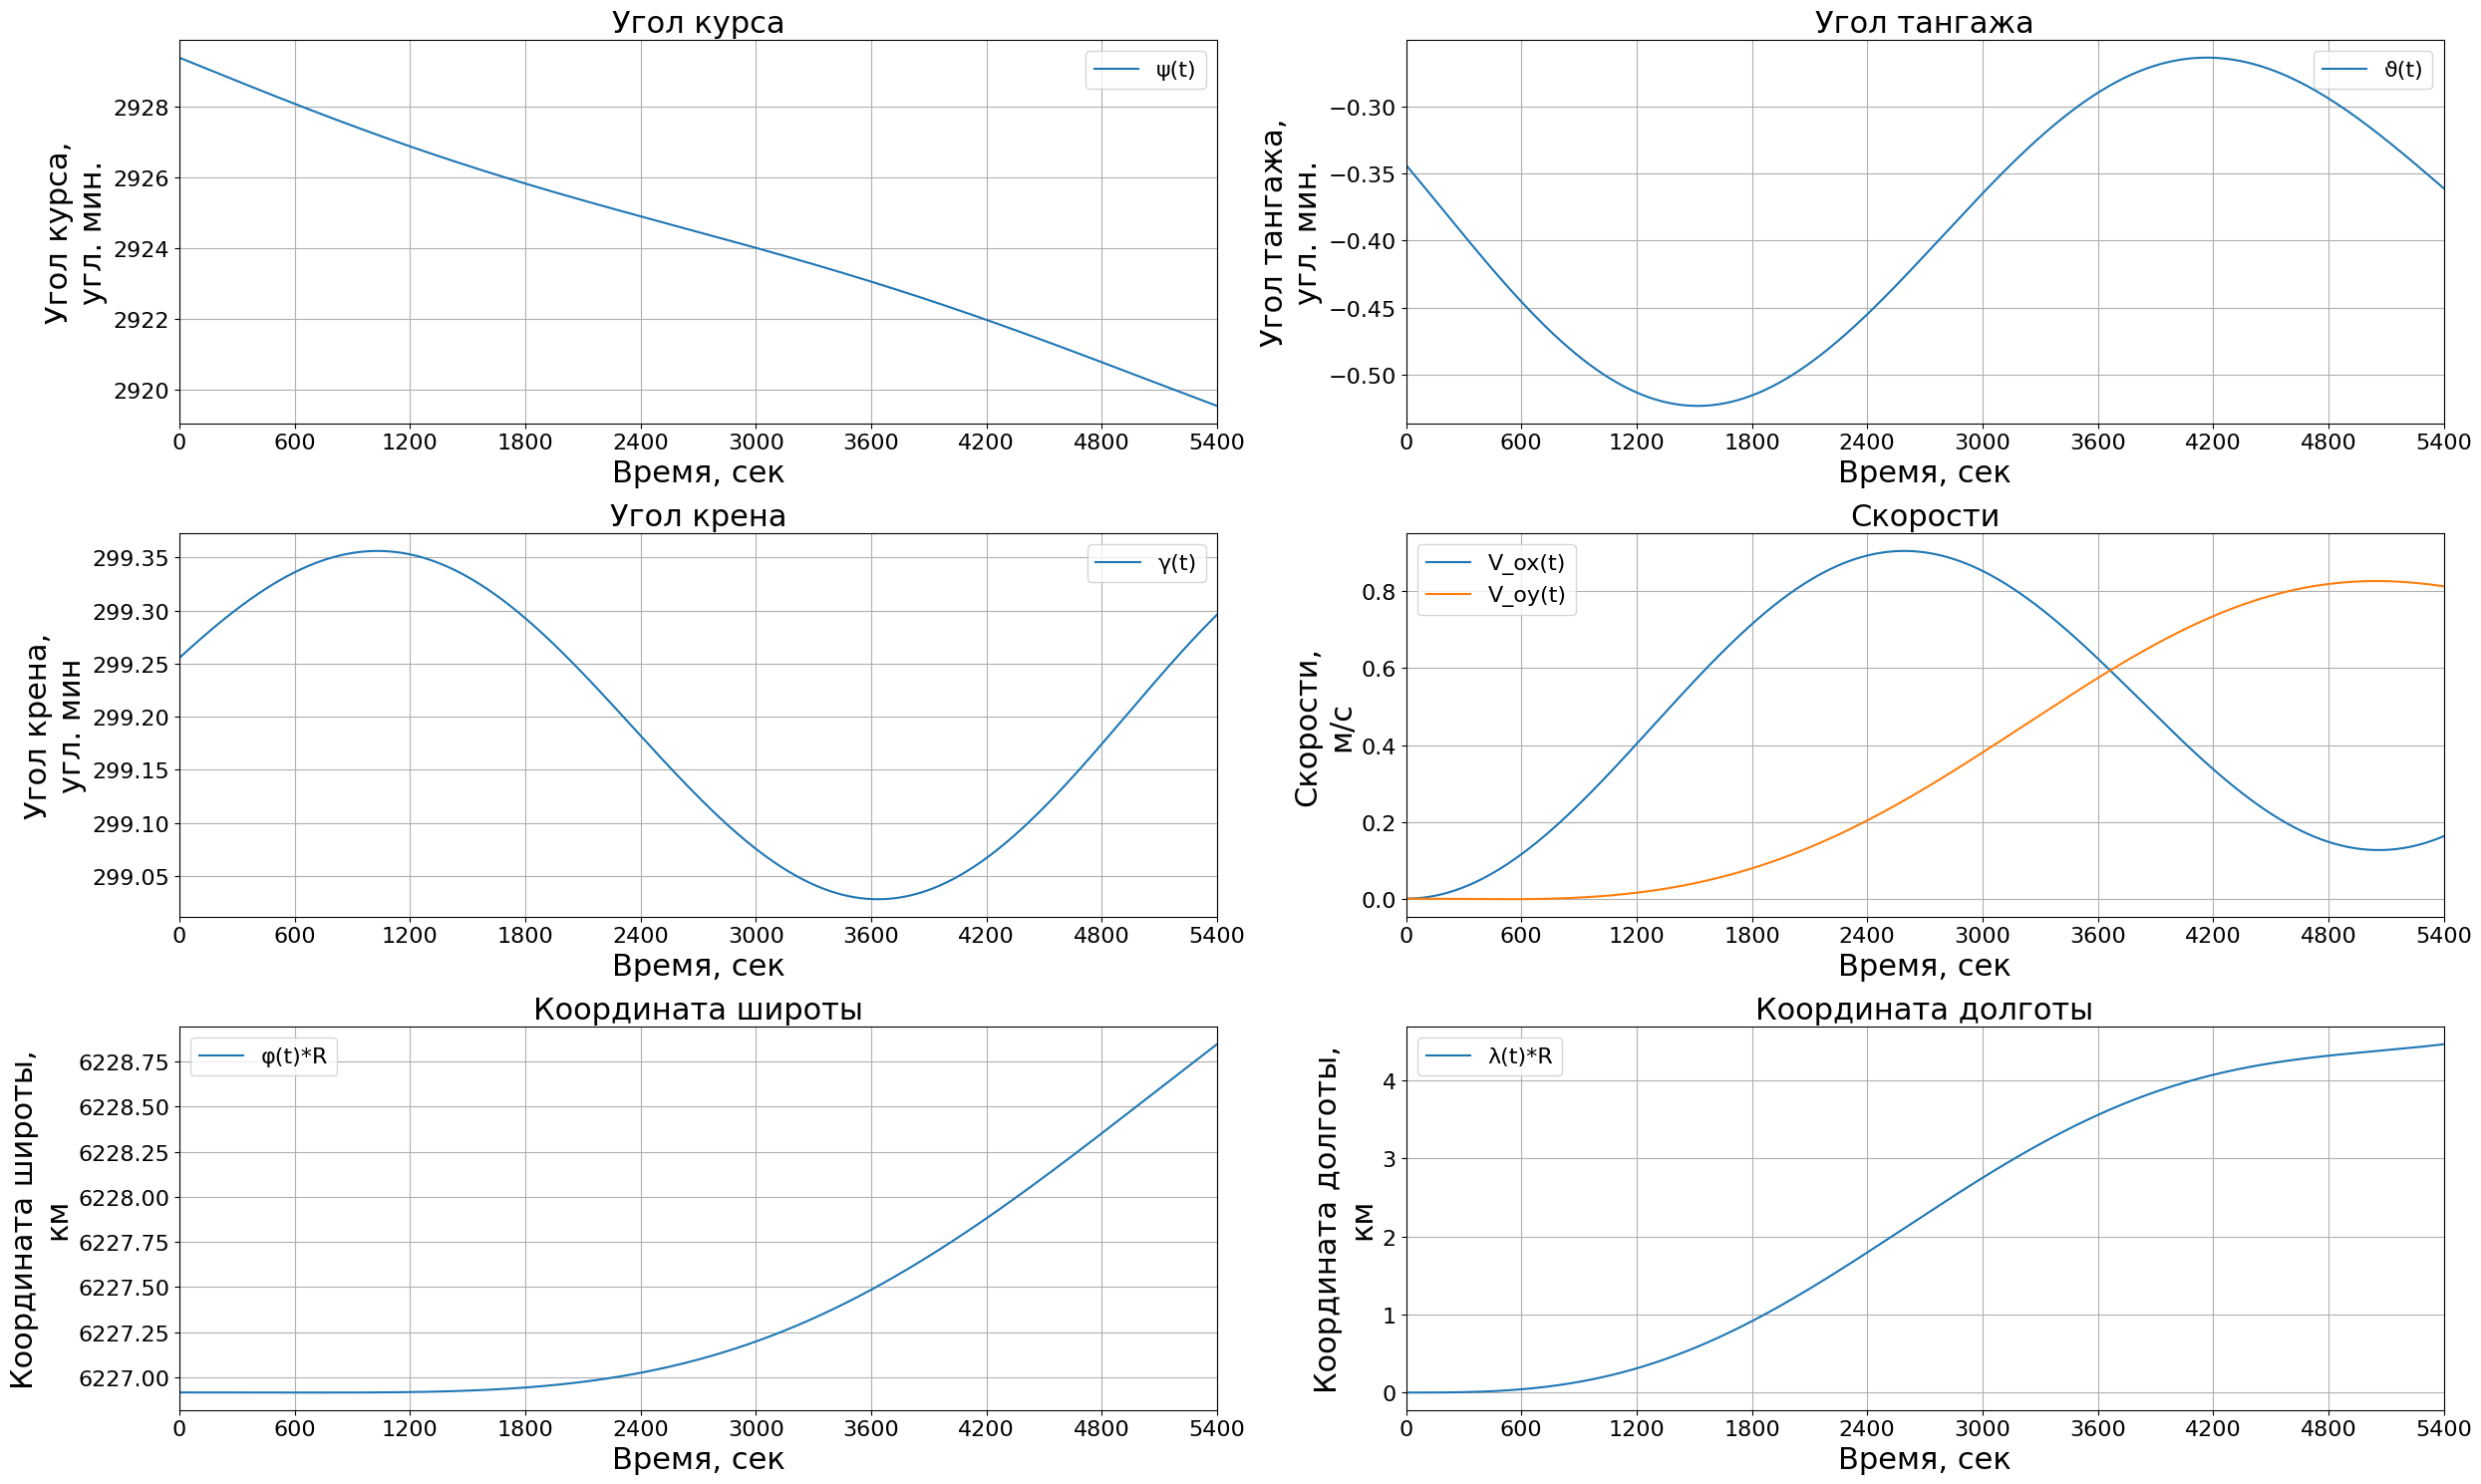

In [114]:
agk_df = pd.read_csv(AGK_RESULTS_FILE)
plot_dataframe(agk_df)

#### ЗК

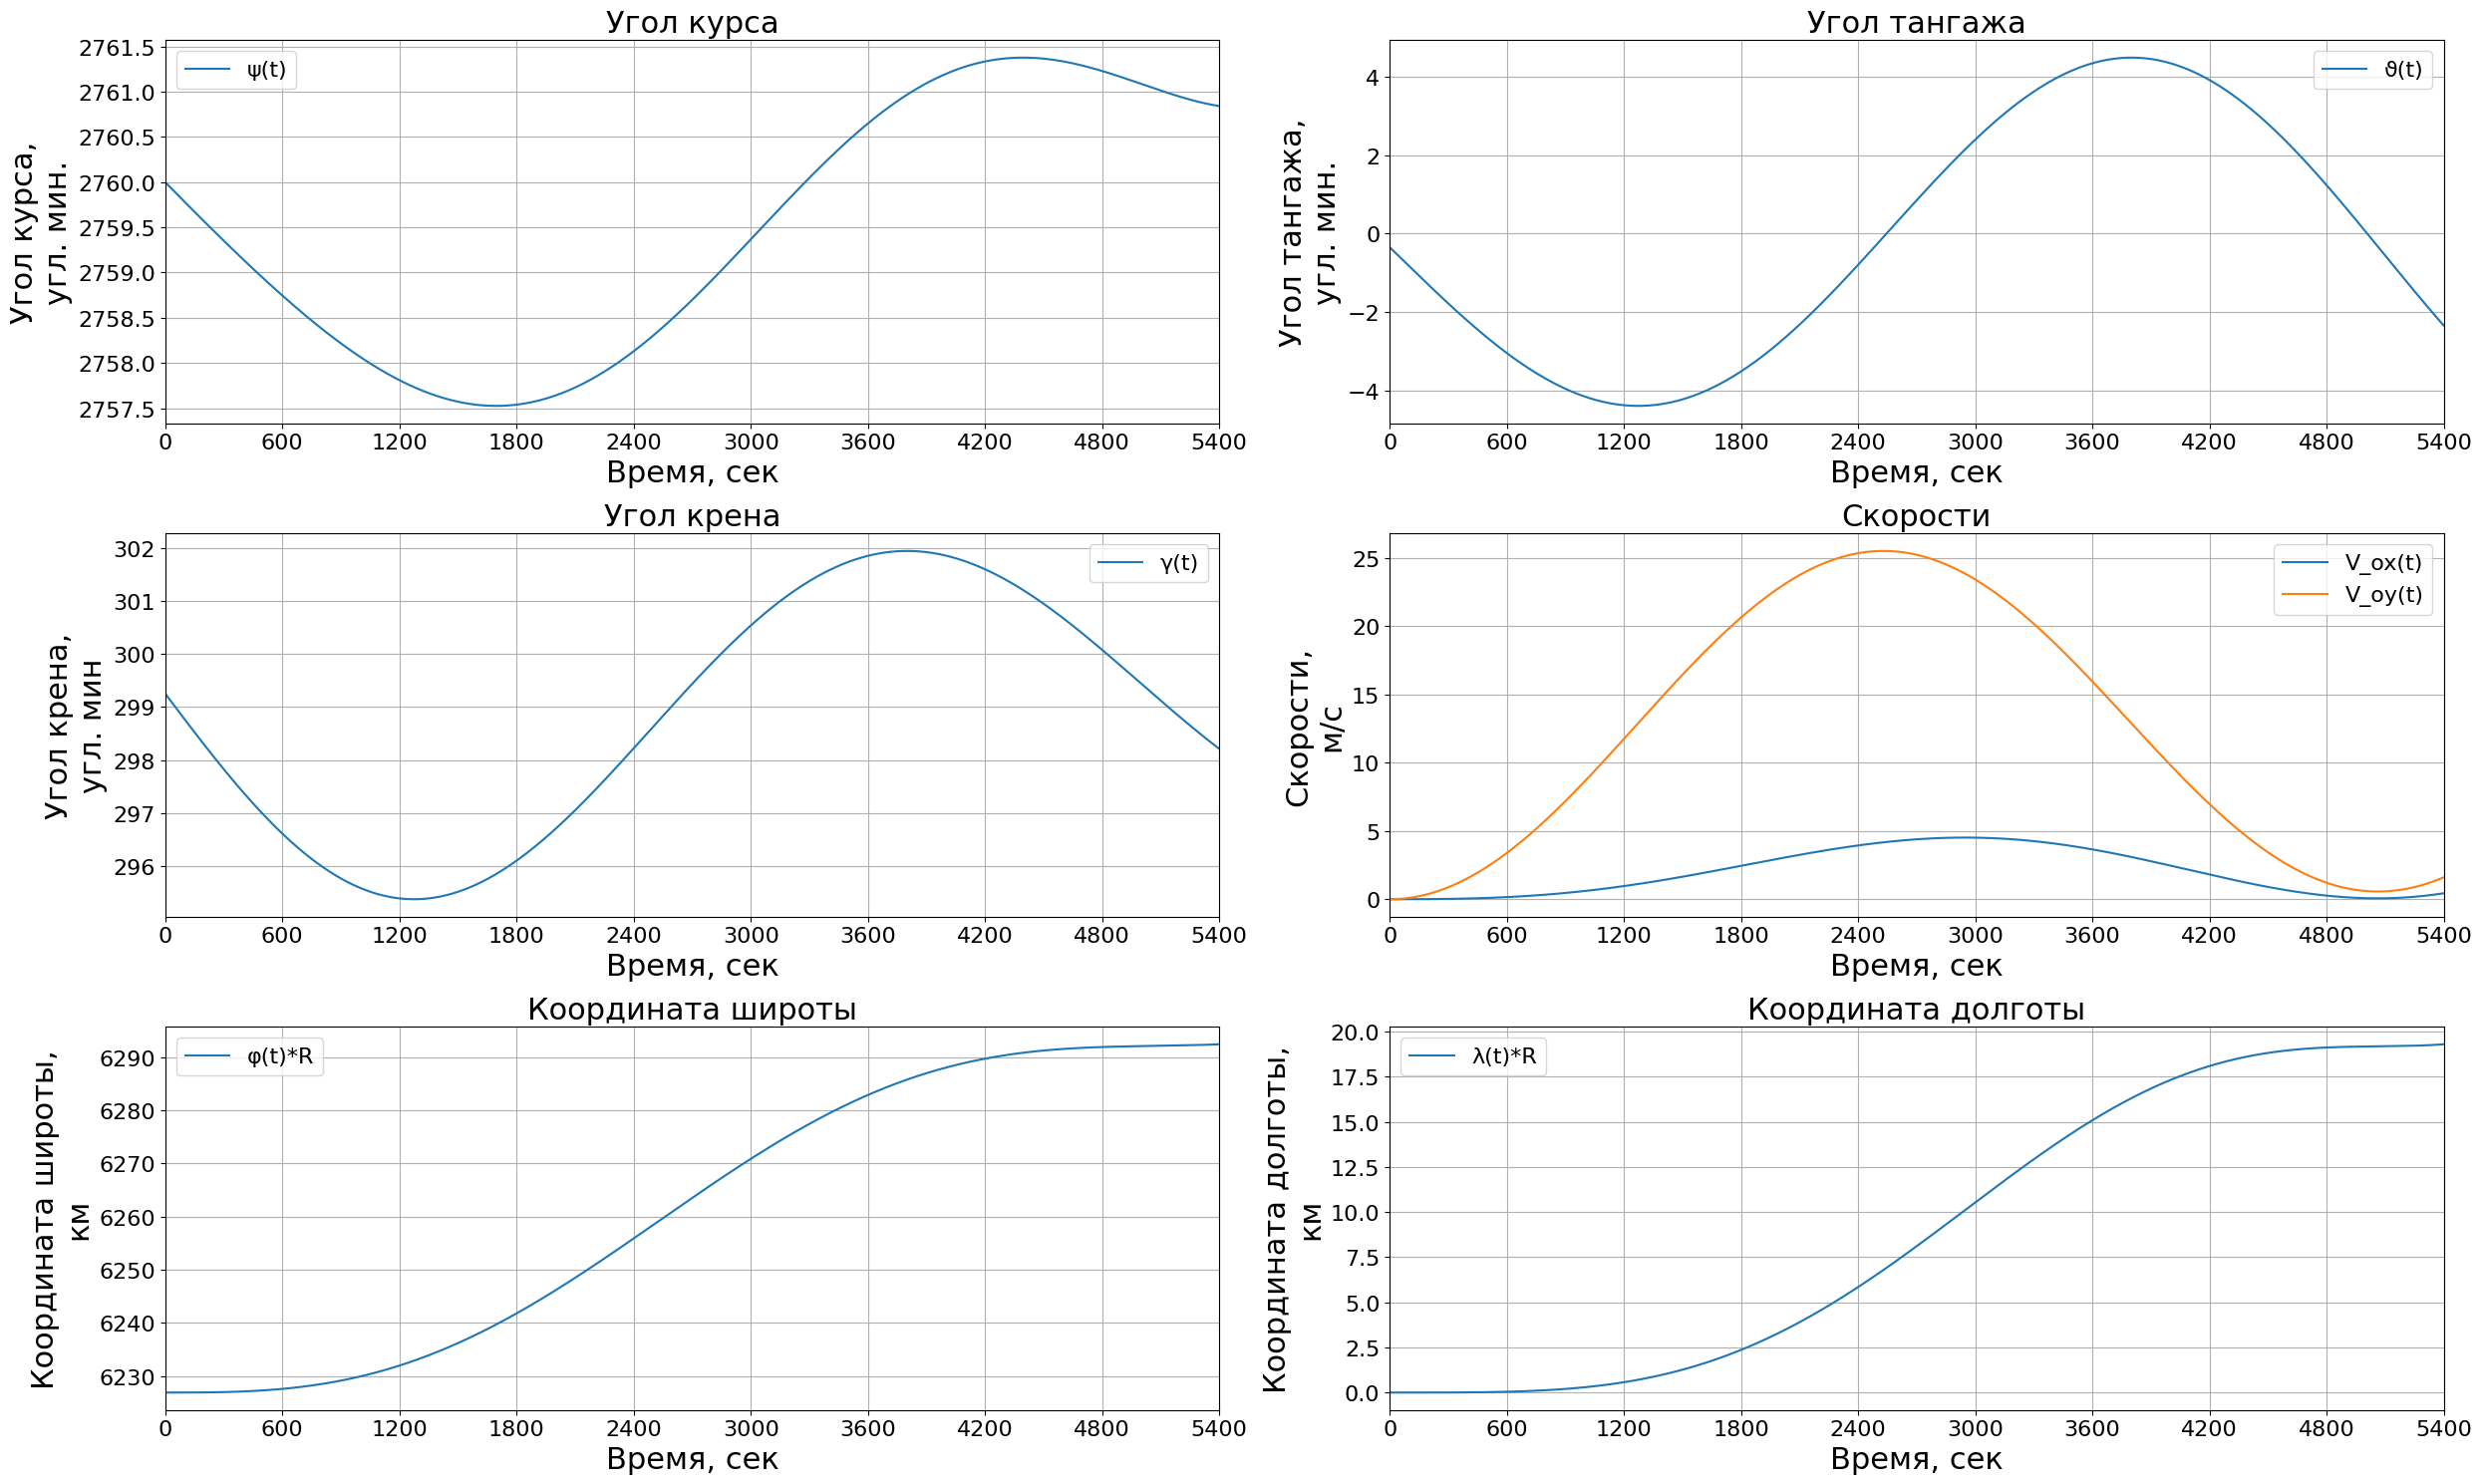

In [115]:
zk_df = pd.read_csv(ZK_RESULTS_FILE)
plot_dataframe(zk_df)

### Ошибки полученные по уравнениям для АГК

#### Функция отрисовки

In [116]:
units_of_measurement = ['угл. мин.', 'м/с', 'угл. мин.', 'угл. мин.', 'км']

def build_diff_chart(algo, formula):
    plt.figure(figsize=(15, 35))

    counter = 0
    for chart in ['Ошибки вертикали', 'Ошибки по скорости', 'Ошибки углов тангажа и крена', 'Ошибки угла курса', 'Ошибки координат']:
        counter += 1

        plt.subplot(5, 1, counter)
        plt.grid()
        plt.title(chart, fontsize=22)
        
        match chart:
            case 'Ошибки вертикали':
                plt.plot(algo['t'], algo['Φ_oy(t)']*180/np.pi*60, label='Φ_oy(t) Алгоритм МНК', linewidth=3)
                plt.plot(algo['t'], algo['Φ_ox(t)']*180/np.pi*60, label='Φ_ox(t) Алгоритм МНК', linewidth=3)
                plt.plot(formula['t'], formula['Φ_oy(t)']*180/np.pi*60, '--', label='Φ_oy(t) Формульно', linewidth=3)
                plt.plot(formula['t'], formula['Φ_ox(t)']*180/np.pi*60, '--', label='Φ_ox(t) Формульно', linewidth=3)
            case 'Ошибки по скорости':
                plt.plot(algo['t'], algo['velocity_x_ref'], label='ΔV_ox(t) Алгоритм МНК', linewidth=3)
                plt.plot(algo['t'], algo['velocity_y_ref'], label='ΔV_oy(t) Алгоритм МНК', linewidth=3)
                plt.plot(formula['t'], formula['velocity_x_ref'], '--', label='ΔV_ox(t) Формульно', linewidth=3)
                plt.plot(formula['t'], formula['velocity_y_ref'], '--', label='ΔV_oy(t) Формульно', linewidth=3)
            case 'Ошибки углов тангажа и крена':
                plt.plot(algo['t'], algo['pitch']*180/np.pi*60, label='Δθ(t) Алгоритм МНК', linewidth=3)
                plt.plot(algo['t'], algo['roll']*180/np.pi*60, label='Δγ(t) Алгоритм МНК', linewidth=3)
                plt.plot(formula['t'], formula['pitch']*180/np.pi*60, '--', label='Δθ(t) Формульно', linewidth=3)
                plt.plot(formula['t'], formula['roll']*180/np.pi*60, '--', label='Δγ(t) Формульно', linewidth=3)
            case 'Ошибки угла курса':
                plt.plot(algo['t'], algo['heading']*180/np.pi*60, label='ΔΨ(t) Алгоритм МНК', linewidth=3)
                plt.plot(formula['t'], formula['heading']*180/np.pi*60, '--', label='ΔΨ(t) Формульно', linewidth=3)
            case 'Ошибки координат':
                plt.plot(algo['t'], algo['longitude'] * RADIUS_EARTH / 1000, label='Δλ(t)*R Алгоритм МНК', linewidth=3)
                plt.plot(algo['t'], algo['latitude'] * RADIUS_EARTH / 1000, label='Δφ(t)*R Алгоритм МНК', linewidth=3)
                plt.plot(formula['t'], formula['longitude'] * RADIUS_EARTH / 1000, '--', label='Δλ(t)*R Формульно', linewidth=3)
                plt.plot(formula['t'], formula['latitude'] * RADIUS_EARTH / 1000, '--', label='Δφ(t)*R Формульно', linewidth=3)
        
        plt.ylabel(f'{chart},\n{units_of_measurement[counter-1]}', rotation=90, fontsize=22)
        plt.xlabel('Время, сек', fontsize=22)
        plt.xlim(0, end_time)
        plt.yticks(fontsize=16)
        plt.xticks(np.arange(0, end_time + 600, 600), fontsize=16)  # Установка интервалов по 600 секунд
        plt.legend(fontsize=16)

    plt.tight_layout()
    plt.show()

#### АГК по формулам

In [117]:
# АГК
time_arr = np.linspace(0, end_time, int(end_time * 4))
coefficients_mtrx: Annotated[np.array, 'Матрица коэффициентов, берётся из уравнения ошибок'] = np.array([
    [0,     w_oz,   -w_oy,  0,                              -1/R,                       0,                          0],
    [-w_oz, 0,      w_ox,   1/R,                            0,                          -U*np.sin(base_latitude),   0],
    [w_oy,  -w_ox,  0,      np.tan(base_latitude)/R,        0,                          U*np.cos(base_latitude),    0],
    [0,     -g,     0,      0,                              2*U*np.sin(base_latitude),  0,                          0],
    [g,     0,      0,      -2*U*np.sin(base_latitude),     0,                          0,                          0],
    [0,     0,      0,      0,                              1/R,                        0,                          0],
    [0,     0,      0,      1/(R * np.cos(base_latitude)),  0,                          0,                          0]
], dtype=np.longdouble)


charts_diff_agk: dict = {
    't': time_arr,
    'Φ_oy(t)': np.zeros((len(time_arr)), dtype=np.longdouble),
    'Φ_ox(t)': np.zeros((len(time_arr)), dtype=np.longdouble),
    'ΔV_ox(t)': np.zeros((len(time_arr)), dtype=np.longdouble),
    'ΔV_oy(t)': np.zeros((len(time_arr)), dtype=np.longdouble),
    'Δλ(t)*R': np.zeros((len(time_arr)), dtype=np.longdouble),
    'Δφ(t)*R': np.zeros((len(time_arr)), dtype=np.longdouble),
    'Δθ(t)': np.zeros((len(time_arr)), dtype=np.longdouble),
    'Δγ(t)': np.zeros((len(time_arr)), dtype=np.longdouble),
    'Φ_oz(t)': np.zeros((len(time_arr)), dtype=np.longdouble),
}


inti_conditions_agk_mtrx = np.array([
    -da_oy/g,
     da_ox/g,
    (d_heading_agk),
    0,
    0,
    0,
    0,
], np.longdouble)

drift_mtrx = np.array([
    -dw_ox,
    -dw_oy,
    -dw_oz,
     da_ox,
     da_oy,
         0,
         0,
], dtype=np.longdouble)


e = np.identity(len(coefficients_mtrx), dtype=np.longdouble)


solve_agk_mtrx = np.zeros((len(time_arr), len(coefficients_mtrx)), dtype=np.longdouble)
solve_agk_mtrx[0] = inti_conditions_agk_mtrx


charts_diff_agk['Φ_ox(t)'][0] = solve_agk_mtrx[0][0]
charts_diff_agk['Φ_oy(t)'][0] = solve_agk_mtrx[0][1]
charts_diff_agk['Φ_oz(t)'][0] = solve_agk_mtrx[0][2]
charts_diff_agk['ΔV_ox(t)'][0] = solve_agk_mtrx[0][3]
charts_diff_agk['ΔV_oy(t)'][0] = solve_agk_mtrx[0][4]
charts_diff_agk['Δφ(t)*R'][0] = solve_agk_mtrx[0][5]
charts_diff_agk['Δλ(t)*R'][0] = solve_agk_mtrx[0][6]


for i in range(len(time_arr) - 1):

    h = time_arr[i+1] - time_arr[i]

    solve_agk_mtrx[i+1] = ((e + coefficients_mtrx * h) @ solve_agk_mtrx[i]) + h * drift_mtrx

    charts_diff_agk['Φ_ox(t)'][i+1] = solve_agk_mtrx[i+1][0]
    charts_diff_agk['Φ_oy(t)'][i+1] = solve_agk_mtrx[i+1][1]
    charts_diff_agk['Φ_oz(t)'][i+1] = solve_agk_mtrx[i+1][2]

    charts_diff_agk['ΔV_ox(t)'][i+1] = solve_agk_mtrx[i+1][3]
    charts_diff_agk['ΔV_oy(t)'][i+1] = solve_agk_mtrx[i+1][4]
    
    charts_diff_agk['Δφ(t)*R'][i+1] = solve_agk_mtrx[i+1][5]
    charts_diff_agk['Δλ(t)*R'][i+1] = solve_agk_mtrx[i+1][6]

charts_diff_agk['Δθ(t)'] = -(charts_diff_agk['Φ_ox(t)']*np.cos(heading) - charts_diff_agk['Φ_oy(t)']*np.sin(heading))
charts_diff_agk['Δγ(t)'] = -(charts_diff_agk['Φ_oy(t)']*np.cos(heading) + charts_diff_agk['Φ_ox(t)']*np.sin(heading))/np.cos(pitch)
charts_diff_agk['ΔΨ(t)'] = charts_diff_agk['Φ_oz(t)']-(charts_diff_agk['Φ_ox(t)']*np.cos(heading) + charts_diff_agk['Φ_oy(t)']*np.sin(heading))*np.tan(pitch)

#### Сравнение ошибок по АГК и по формулам

C:\Users\andre\AppData\Local\Temp\ipykernel_16604\1766127586.py:46: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


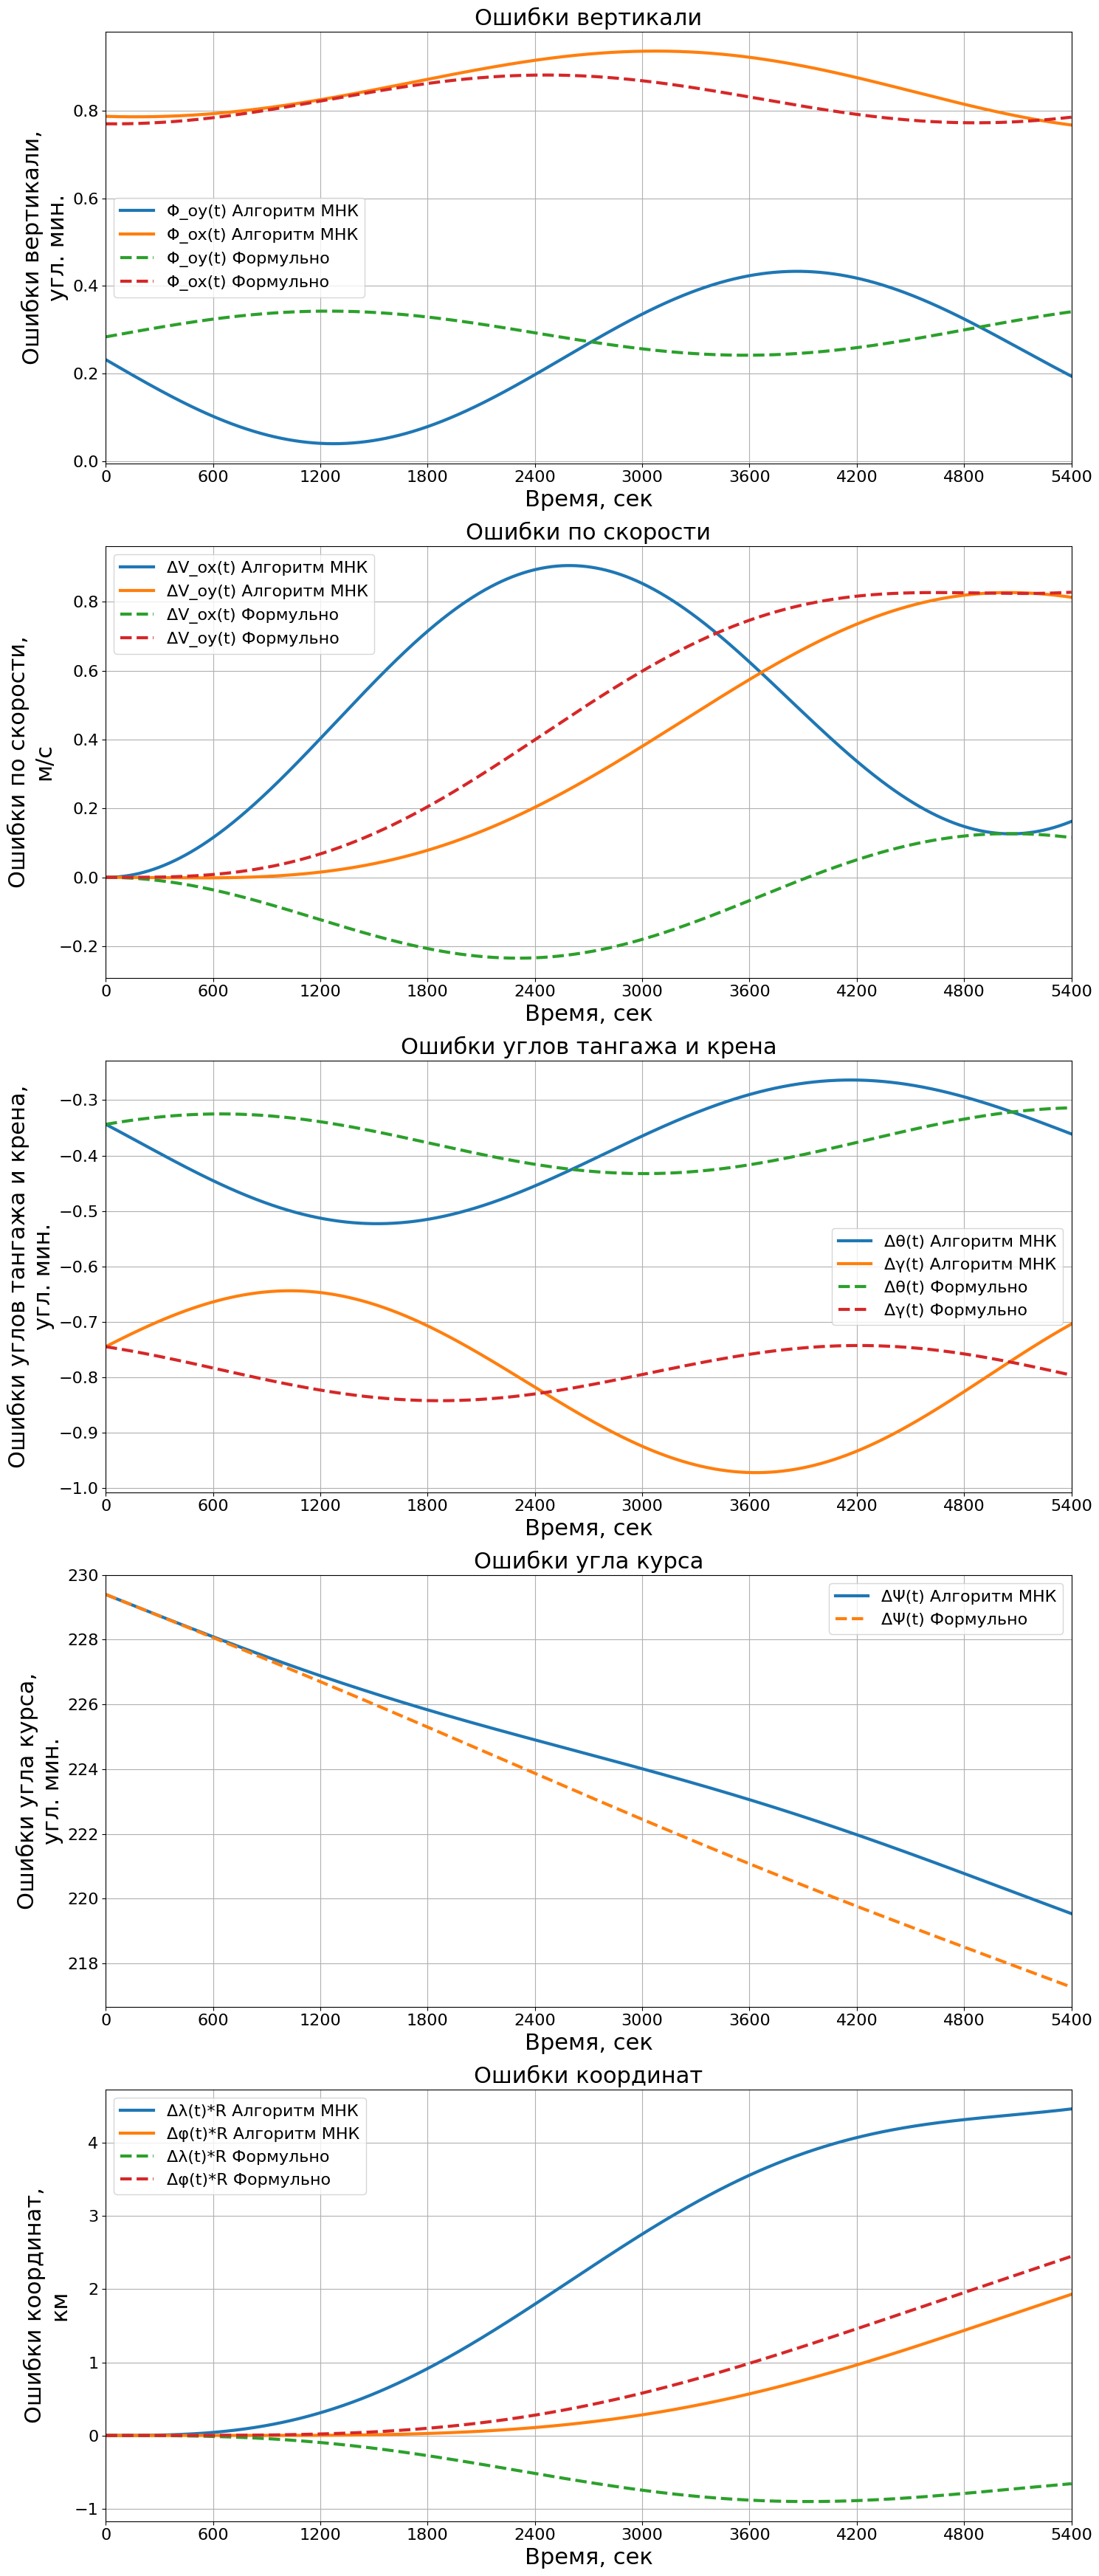

In [119]:
agk_err = agk_df.copy()
agk_err['pitch'] -= pitch
agk_err['roll'] -= roll
agk_err['heading'] -= heading
agk_err['velocity_x_ref'] -= 0
agk_err['velocity_y_ref'] -= 0
agk_err['latitude'] -= base_latitude
agk_err['longitude'] -= base_longitude
agk_err.t = agk_df.t

agk_err['Φ_ox(t)'] = -((agk_err['pitch']) * np.cos(agk_df['heading']) + (agk_err['roll']) * np.cos(agk_df['pitch']) * np.sin(agk_df['heading']))
agk_err['Φ_oy(t)'] = -((agk_err['roll']) * np.cos(agk_df['pitch']) * np.cos(agk_df['heading']) - (agk_err['pitch']) * np.sin(agk_df['heading']))

charts_diff_agk['pitch'] = -(charts_diff_agk['Φ_ox(t)']*np.cos(heading) - charts_diff_agk['Φ_oy(t)']*np.sin(heading))
charts_diff_agk['roll'] = -(charts_diff_agk['Φ_oy(t)']*np.cos(heading) + charts_diff_agk['Φ_ox(t)']*np.sin(heading))/np.cos(pitch)
charts_diff_agk['heading'] = charts_diff_agk['Φ_oz(t)'] - (charts_diff_agk['Φ_ox(t)']*np.cos(heading) + charts_diff_agk['Φ_oy(t)']*np.sin(heading))*np.tan(pitch)
charts_diff_agk['velocity_x_ref'] = charts_diff_agk['ΔV_ox(t)']
charts_diff_agk['velocity_y_ref'] = charts_diff_agk['ΔV_oy(t)']
charts_diff_agk['latitude'] = charts_diff_agk['Δφ(t)*R']
charts_diff_agk['longitude'] = charts_diff_agk['Δλ(t)*R']

build_diff_chart(agk_err, charts_diff_agk)

### Ошибки полученные по уравнения для ЗК

#### ЗК по формулам

In [120]:
coefficients_mtrx = np.array([
    [0, w_oz, -w_oy, 0, -1/R, 0, 0],
    [-w_oz, 0, w_ox, 1/R, 0, -U*np.sin(base_latitude), 0],
    [w_oy, -w_ox, 0, np.tan(base_latitude)/R, 0, U*np.cos(base_latitude), 0],
    [0, -g, 0, 0, 2*U*np.sin(base_latitude), 0, 0],
    [g, 0, 0, -2*U*np.sin(base_latitude), 0, 0, 0],
    [0, 0, 0, 0, 1/R, 0, 0],
    [0, 0, 0, 1/R/np.cos(base_latitude), 0, 0, 0]
], dtype=np.longdouble)


charts_diff_zk: dict = {
    't': time_arr,
    'Φ_oy(t)': np.zeros((len(time_arr)), dtype=np.longdouble),
    'Φ_ox(t)': np.zeros((len(time_arr)), dtype=np.longdouble),
    'ΔV_ox(t)': np.zeros((len(time_arr)), dtype=np.longdouble),
    'ΔV_oy(t)': np.zeros((len(time_arr)), dtype=np.longdouble),
    'Δλ(t)*R': np.zeros((len(time_arr)), dtype=np.longdouble),
    'Δφ(t)*R': np.zeros((len(time_arr)), dtype=np.longdouble),
    'Δθ(t)': np.zeros((len(time_arr)), dtype=np.longdouble),
    'Δγ(t)': np.zeros((len(time_arr)), dtype=np.longdouble),
    'Φ_oz(t)': np.zeros((len(time_arr)), dtype=np.longdouble),
}


inti_conditions_zk_mtrx = np.array([
    -da_oy/g,
     da_ox/g,
    (d_heading_zk),
    0,
    0,
    0,
    0,
], np.longdouble)

drift_mtrx = np.array([
    -dw_ox,
    -dw_oy,
    -dw_oz,
     da_ox,
     da_oy,
         0,
         0,
], dtype=np.longdouble)


e = np.identity(len(coefficients_mtrx), dtype=np.longdouble)


solve_zk_mtrx = np.zeros((len(time_arr), len(coefficients_mtrx)), dtype=np.longdouble)
solve_zk_mtrx[0] = inti_conditions_zk_mtrx


charts_diff_zk['Φ_ox(t)'][0] = solve_zk_mtrx[0][0]
charts_diff_zk['Φ_oy(t)'][0] = solve_zk_mtrx[0][1]
charts_diff_zk['Φ_oz(t)'][0] = solve_zk_mtrx[0][2]
charts_diff_zk['ΔV_ox(t)'][0] = solve_zk_mtrx[0][3]
charts_diff_zk['ΔV_oy(t)'][0] = solve_zk_mtrx[0][4]
charts_diff_zk['Δφ(t)*R'][0] = solve_zk_mtrx[0][5]
charts_diff_zk['Δλ(t)*R'][0] = solve_zk_mtrx[0][6]


for i in range(len(time_arr) - 1):

    h = time_arr[i+1] - time_arr[i]

    solve_zk_mtrx[i+1] = ((e + coefficients_mtrx * h) @ solve_zk_mtrx[i]) + h * drift_mtrx
    charts_diff_zk['Φ_ox(t)'][i+1] = solve_zk_mtrx[i+1][0]
    charts_diff_zk['Φ_oy(t)'][i+1] = solve_zk_mtrx[i+1][1]
    charts_diff_zk['Φ_oz(t)'][i+1] = solve_zk_mtrx[i+1][2]

    charts_diff_zk['ΔV_ox(t)'][i+1] = solve_zk_mtrx[i+1][3]
    charts_diff_zk['ΔV_oy(t)'][i+1] = solve_zk_mtrx[i+1][4]

    charts_diff_zk['Δφ(t)*R'][i+1] = solve_zk_mtrx[i+1][5]
    charts_diff_zk['Δλ(t)*R'][i+1] = solve_zk_mtrx[i+1][6]

charts_diff_zk['Δθ(t)'] = -(charts_diff_zk['Φ_ox(t)']*np.cos(heading)
                            - charts_diff_zk['Φ_oy(t)']*np.sin(heading))
charts_diff_zk['Δγ(t)'] = -(charts_diff_zk['Φ_oy(t)']*np.cos(heading)
                            + charts_diff_zk['Φ_ox(t)']*np.sin(heading))/np.cos(pitch)


#### Сравнение ошибок по ЗК и по формулам

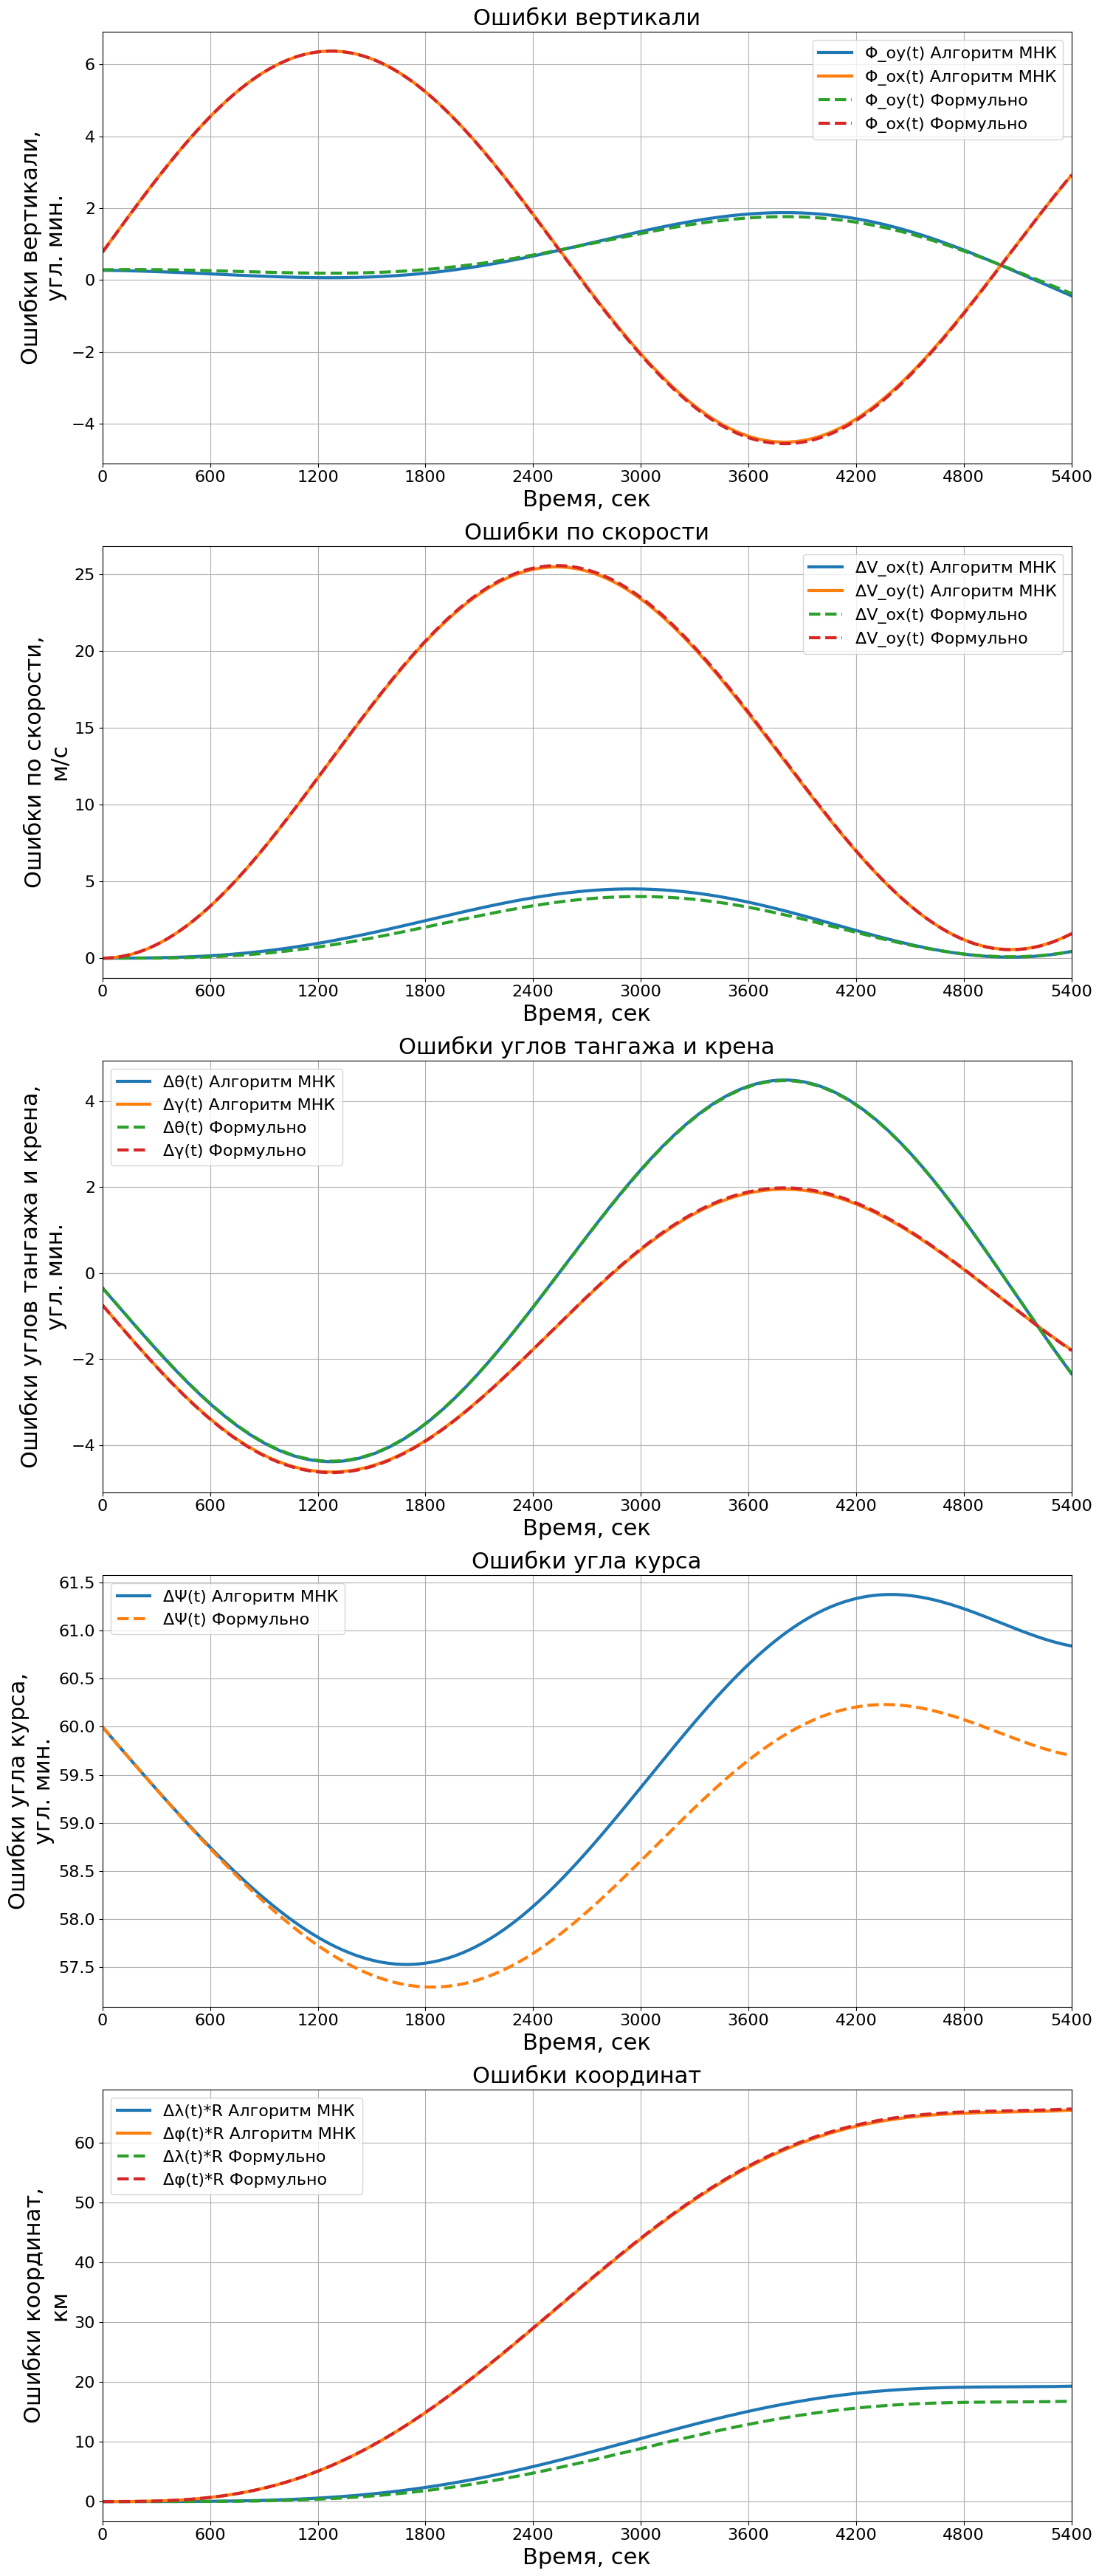

In [121]:
zk_err = zk_df.copy()
zk_err['pitch'] -= pitch
zk_err['roll'] -= roll
zk_err['heading'] -= heading
zk_err['velocity_x_ref'] -= 0
zk_err['velocity_y_ref'] -= 0
zk_err['latitude'] -= base_latitude
zk_err['longitude'] -= base_longitude
zk_err.t = zk_df.t

zk_err['Φ_ox(t)'] = -((zk_err['pitch']) * np.cos(zk_df['heading']) + (zk_err['roll']) * np.cos(zk_df['pitch']) * np.sin(zk_df['heading']))
zk_err['Φ_oy(t)'] = -((zk_err['roll']) * np.cos(zk_df['pitch']) * np.cos(zk_df['heading']) - (zk_err['pitch']) * np.sin(zk_df['heading']))

charts_diff_zk['pitch'] = -(charts_diff_zk['Φ_ox(t)']*np.cos(heading) - charts_diff_zk['Φ_oy(t)']*np.sin(heading))
charts_diff_zk['roll'] = -(charts_diff_zk['Φ_oy(t)']*np.cos(heading) + charts_diff_zk['Φ_ox(t)']*np.sin(heading))/np.cos(pitch)
charts_diff_zk['heading'] = charts_diff_zk['Φ_oz(t)'] - (charts_diff_zk['Φ_ox(t)']*np.cos(heading) + charts_diff_zk['Φ_oy(t)']*np.sin(heading))*np.tan(pitch)
charts_diff_zk['velocity_x_ref'] = charts_diff_zk['ΔV_ox(t)']
charts_diff_zk['velocity_y_ref'] = charts_diff_zk['ΔV_oy(t)']
charts_diff_zk['latitude'] = charts_diff_zk['Δφ(t)*R']
charts_diff_zk['longitude'] = charts_diff_zk['Δλ(t)*R']

build_diff_chart(zk_err, charts_diff_zk)

### Начальный кватернион

In [122]:
# ДЛЯ АГК
[
    [c_11, c_12, c_13],
    [c_21, c_22, c_23],
    [c_31, c_32, c_33],
] = calc_body_to_ref(heading_agk, pitch_agk, roll_agk)

# Начальный кватернион через элементы матрицы МНК
q_0 = 1/2 * np.sqrt(c_11 + c_22 + c_33 + 1)
q_1 = (c_32 - c_23) / (4 * q_0)
q_2 = (c_13 - c_31) / (4 * q_0)
q_3 = (c_21 - c_12) / (4 * q_0)

Q = np.array([q_0, q_1, q_2, q_3], dtype=np.longdouble)
print(f'Начальный кватернион при выставке по АГК: Q = {Q}')

Начальный кватернион при выставке по АГК: Q = [ 0.9097364   0.01793723  0.0396419  -0.41290005]


In [123]:
# ДЛЯ ЗК
[
    [c_11, c_12, c_13],
    [c_21, c_22, c_23],
    [c_31, c_32, c_33],
] = calc_body_to_ref(heading_zk, pitch_zk, roll_zk)

# Начальный кватернион через элементы матрицы МНК
q_0 = 1/2 * np.sqrt(c_11 + c_22 + c_33 + 1)
q_1 = (c_32 - c_23) / (4 * q_0)
q_2 = (c_13 - c_31) / (4 * q_0)
q_3 = (c_21 - c_12) / (4 * q_0)

Q = np.array([q_0, q_1, q_2, q_3], dtype=np.longdouble)
print(f'Начальный кватернион при выставке по ЗК: Q = {Q}')

Начальный кватернион при выставке по ЗК: Q = [ 0.91963223  0.0169552   0.04007176 -0.39036308]


# Legacy

### Ошибки горизонтирования при выставке по АГК

In [124]:
# Дрейфовые угловые скорости ДУС при выставке по АГК
dw_com_ox_agk: Annotated[np.longdouble, 'Дрейфовая угловая скорость ДУС'] = np.longdouble(dw_ox - U*np.sin(base_latitude)*da_ox/g + U*np.cos(base_latitude)*dazimuth_agk)
dw_com_oy_agk: Annotated[np.longdouble, 'Дрейфовая угловая скорость ДУС'] = np.longdouble(U*np.sin(base_latitude)*(-da_oy/g)+dw_oy)

NameError: name 'dazimuth_agk' is not defined

In [ ]:
# Ошибки горизонтирования (выставки) при выставке по АГК
dФox_agk =  np.longdouble(-da_oy/g - dw_com_ox_agk * np.sin(v*0) / v)
dФoy_agk =  np.longdouble(da_ox/g - dw_com_oy_agk * np.sin(v*0) / v)

print(f"Северный канал: {np.rad2deg(dФox_agk)}° = {np.rad2deg(dФox_agk*60)}' = {dФox_agk} рад")
print(f"Восточный канал: {np.rad2deg(dФoy_agk)}° = {np.rad2deg(dФox_agk*60)}' = {dФoy_agk} рад")

### Ошибки горизонтирования при выставке по ЗК

In [ ]:
# Дрейфовые угловые скорости ДУС при выставке по ЗК
dw_com_ox_zk: Annotated[np.longdouble, 'Дрейфовая угловая скорость ДУС'] = np.longdouble(dw_ox - U*np.sin(base_latitude)*da_ox/g + U*np.cos(base_latitude)*dazimuth_zk)
dw_com_oy_zk: Annotated[np.longdouble, 'Дрейфовая угловая скорость ДУС'] = np.longdouble(U*np.sin(base_latitude)*(-da_oy/g)+dw_oy)

In [ ]:
# Ошибки горизонтирования (выставки) при выставке по ЗК
dФox_zk =  np.longdouble(-da_oy/g - dw_com_ox_zk * np.sin(v*0) / v)
dФoy_zk =  np.longdouble(da_ox/g - dw_com_oy_zk * np.sin(v*0) / v)

print(f'Северный канал: {np.rad2deg(dФox_zk)}° = {np.rad2deg(dФox_zk*60)}` = {dФox_zk} рад')
print(f'Восточный канал: {np.rad2deg(dФoy_zk)}° = {np.rad2deg(dФoy_zk*60)}` = {dФoy_zk} рад')

### Сравнение ошибок моделирования и расчётных ошибок

In [ ]:
# Ошибки поделирования
d_pitch_model: Annotated[np.longdouble, 'Ошибка моделирования по тангажу'] = np.arctan(a_by / np.sqrt(a_bx**2 + a_bz**2))
d_roll_model: Annotated[np.longdouble, 'Ошибка моделирования по крену'] = -np.arctan(a_bx / a_bz)
d_heading_model: Annotated[np.longdouble, 'Ошибка моделирования по курсу'] = np.arctan((a_bx * w_bz - a_bz * w_bx) / (g * w_by - a_by * U*np.sin(base_latitude)))

# Разница
delta_pitch = d_pitch_model - pitch
delta_roll = d_roll_model - roll
delta_heading = d_heading_model - heading

print(f'Разница по тангажу: {np.rad2deg(delta_pitch)}° = {delta_pitch} рад')
print(f'Разница по крену: {np.rad2deg(delta_roll)}° = {delta_roll} рад')
print(f'Разница по курсу: {np.rad2deg(delta_heading)}° = {delta_heading} рад')

### Начальный кватернион (по МНК)

In [ ]:
# Для упрощения жизни переприсвоим элементы матрицы МНК в значения `c_ij`
[
    [c_11, c_12, c_13],
    [c_21, c_22, c_23],
    [c_31, c_32, c_33],
] = body_to_ref

In [ ]:
# Начальный кватернион через элементы матрицы МНК
q_0 = 1/2 * np.sqrt(c_11 + c_22 + c_33 + 1)
q_1 = (c_32 - c_23) / (4 * q_0)
q_2 = (c_13 - c_31) / (4 * q_0)
q_3 = (c_21 - c_12) / (4 * q_0)

Q = np.array([q_0, q_1, q_2, q_3], dtype=np.longdouble)
print(f'Начальный кватернион: {Q}')